In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

path = "../LASER/B-1/"
filename = lambda x: path + "B-1_DoubleSlit_" + str(x) + ".csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  return pos, volt

def plot_data(x):
  pos, volt = get_data(x)
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)}호)")

In [8]:
plot_data(14)

KeyError: 'voltage(mV)'

In [ ]:
from LASER import *

In [19]:
n = 200
center = 5.5e-3 * METER
detecor_pos = np.linspace(1e-3 * METER, 9e-3 * METER, n)
result = []
for pos in detecor_pos:
  result.append(simulate(center, 14, center, pos))
result = np.array(result)

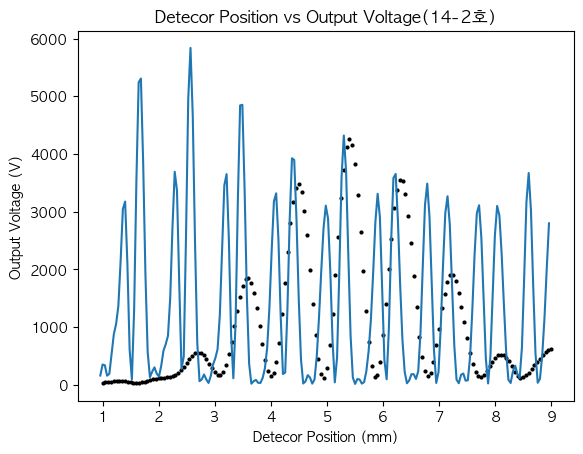

In [20]:
result = np.array(result)
plt.plot(detecor_pos/METER * 1e3 - 0.04, result * 1e37 / 6.3)
plot_data('14-2')

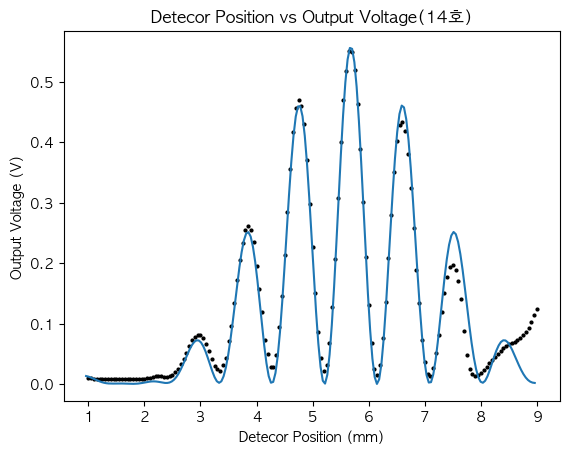

In [29]:
result = np.array(result)
plt.plot(detecor_pos/METER * 1e3 - 0.04, result * 1e26 / 6.3)
plot_data(14)

In [4]:
theta0 = np.array([
  double_left_width,
  double_right_width,
  detector_width,
  blocker_width,
  blocker_points,
  distance1,
  distance2,
  WAVENUMBER,
  gamma
])
simulator(theta0)

<function LASER.simulator.<locals>.simulate(slit_position, slit_type, blocker_position, detector_position, wavenumber=0.0009377888518178487)>

In [ ]:
import torch.nn

